More work on trying to fit one sigma - old 

In [1]:
import numpy as np
import matplotlib


from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
from matplotlib import cm
import scipy.stats as st
import scipy.special as spec



Work with the delta times for the shadow systems

In [2]:
df = pd.read_csv("../csvs/deltatimes.csv")
del df["runstring"]
del df["Unnamed: 0"]
print df.shape
print df["t"].max()
print df["t_shadow"].max()
df.head()


(25000, 2)
1000000000.0
1000000000.0


,t,t_shadow
0,1.235644e+07,8.315081e+07
1,1.348749e+05,2.133072e+05
2,1.276381e+04,9.321519e+03
3,1.000000e+09,1.000000e+09
4,8.791888e+01,8.791888e+01


Assuming they are all one system, what is the mean and sigma?
Calculate it using MLE to determine to most likely value for mu and sigma. 

In [3]:
#Try plotting the integrand, with various values of sigma
def double_gauss(x, sigma, mu):
    #sigma = 10 #for now
    #x are the two x values from the delta times csv file
    vals = 1./(2*np.pi*sigma**2) * np.exp((-(x[0] - mu)**2 -(x[1] -mu)**2) / (2.*sigma**2) )
    return vals

In [4]:
#create a pdframe with different draws and that are not stable
indices = []
for i, vals in enumerate(df.as_matrix()):
    if vals[0] !=1e9 and vals[0] != vals[1]:
        indices.append(i)
        
        
        
        #print i
print len(indices)
plt_d=df.loc[indices]
print plt_d.shape

#try getting each of their contributions assuming sigma is 10.
sigma = 10
num_std = 3.5

sigma_range = np.linspace(100, 1e6, 1000)

areas = np.zeros(( sigma_range.shape[0], plt_d.shape[0])) # include area for each gaussian
plt_d_vals = plt_d.as_matrix()
log_times = np.log(plt_d_vals)

11244
(11244, 2)


Create a grid of mu and sigma centered around those two values, and see how the probabilities vary around those parameters as you move away from them

[ 16.32968811  18.23616649]
[ 11.81210284  12.27048846]
[ 9.45436895  9.14008086]
[ 6.25601719  5.77160556]
[ 9.54300222  6.82451836]
[ 12.79114512  13.37968632]
[ 14.52134551  12.64848558]
[ 17.12029131  14.10735675]
[ 12.82350992  13.41797624]
[ 6.0070941   5.84109357]


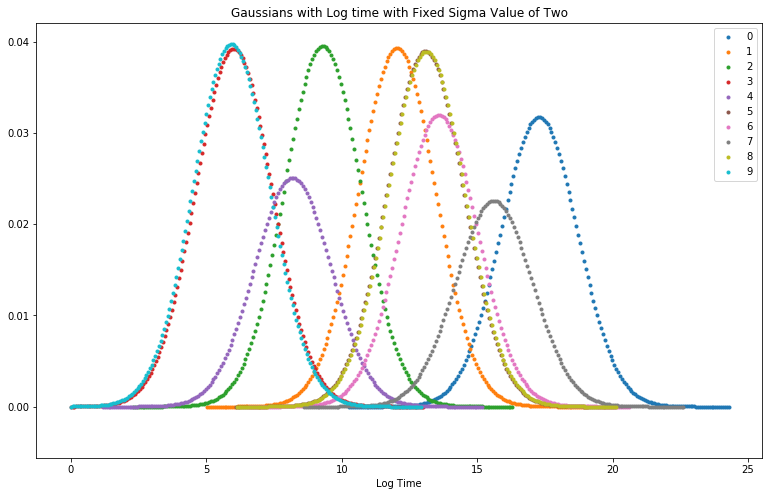

In [5]:
#Try ploting multiple guassians with log time
fig = plt.figure(figsize=(13,8))
ax = fig.add_subplot("111")
#vals = [10,20,30,40]
sigma = 1

for i, vals in enumerate(log_times[:10, :]):
    mid = np.sum(vals)/2.
    print vals
    #what is the best sigma given mu?
    #sigma = 0.5* np.sum(( vals - mid) **2)
    #print sigma
    sigma = 2
    start = mid - (num_std*sigma)
        
    if(start > 0):
        mu = np.linspace(mid - (num_std*sigma) , mid + (num_std*sigma) , 200)
    else:
        mu = np.linspace(0 , mid + (num_std*sigma) , 200)
    
    values = double_gauss(vals, sigma, mu)
    ax.scatter(mu, values, label = str(i), marker = ".")
plt.title("Gaussians with Log time with Fixed Sigma Value of Two")
plt.xlabel("Log Time")
plt.legend()
plt.show()

In [6]:
import time
sigma_range = np.linspace(0.5, 5, 75)

def fit_sigma(log_times, sigma_range):
    prob = np.zeros(( sigma_range.shape[0], log_times.shape[0])) # include area for each gaussia
    start = time.time()

    for j, sigma in enumerate(sigma_range):
        for i, val in enumerate(log_times):
            prob[j][i] = -(val[0] - val[1])**2/(4. *sigma**2) +np.log(1+spec.erf(np.nansum(val)/(2.*sigma))) - np.log(4*np.pi**0.5*sigma)

        #print j
    end = time.time()
    print "Time", (end -start)
    return prob
areas3 = fit_sigma(log_times, sigma_range)

Time 19.9115021229


Try calculating the most likely mu and sigma for each row of two points

In [83]:
#see how the areas change as sigma changes
def sigma_prob_sum(prob):
    summed_prob = np.zeros(prob.shape[0])
    for  i, val in enumerate(prob):
        summed_prob[i] = np.sum(val)
        #print val
        #print np.nansum(val)
    #normalize by the total number of samples
    return summed_prob/prob.shape[0]
    

summed_Areas2 = sigma_prob_sum(areas3)
print sigma_range.shape
print summed_Areas2.shape

(75,)
(75,)


Get rid of the samples where the two times were the same, as not much can be inferred. Many are the same because there are both 1e9, which means they were stable. Some have stability times magnitudes smaller, but were still the same, so then the parameter perturbed did not affect its stability at all 

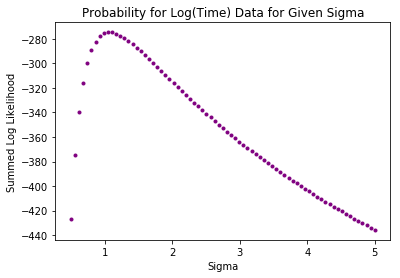

In [44]:
def plotting(sigma_range, probs, title):
    plt.scatter(sigma_range, probs, color = "purple", marker =".")
    plt.title(title)
    plt.ylabel("Summed Log Likelihood")
    plt.xlabel("Sigma")
    plt.show()
plotting(sigma_range, summed_Areas2, "Probability for Log(Time) Data for Given Sigma")

Try using MCMC to find the most likely value of sigma and mu

In [9]:
df_inital = pd.read_csv("../csvs/initial_orbital_elements.csv", index_col=0)
del df_inital["Rel_Eerr"]
del df_inital["Stable"]
del df_inital["runstring"]
print df_inital.keys().values
df_inital.head()

['instability_time' 'RHill12' 'RHill23' 'beta12' 'beta23' 'm1' 'a1' 'P1'
 'e1' 'pomega1' 'inc1' 'Omega1' 'f1' 'm2' 'a2' 'P2' 'e2' 'pomega2' 'inc2'
 'Omega2' 'f2' 'm3' 'a3' 'P3' 'e3' 'pomega3' 'inc3' 'Omega3' 'f3']


,instability_time,RHill12,RHill23,beta12,beta23,m1,a1,P1,e1,pomega1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,1.235644e+07,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,0.999983,0.005031,3.171041,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,1.348749e+05,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,1.000000,0.010350,-3.564030,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,1.276381e+04,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,0.999963,0.051912,0.995149,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,1.000000e+09,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,1.000000,0.000152,-3.328433,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,8.791888e+01,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,1.000000,0.001457,1.738448,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392


In [10]:
df_inital2 = pd.read_csv("../csvs/short_integration_features.csv", index_col=0)
del df_inital2["Rel_Eerr"]
del df_inital2["Rel_Eerr_short"]
del df_inital2["runstring"]
print df_inital2.keys().values
df_inital2.head()

['Stable' 'instability_time' 't_final_short' 'avg_a1' 'std_a1' 'max_a1'
 'min_a1' 'norm_std_a1' 'norm_max_a1' 'norm_std_window10_a1'
 'norm_max_window10_a1' 'avg_e1' 'std_e1' 'max_e1' 'min_e1' 'norm_std_e1'
 'norm_max_e1' 'norm_std_window10_e1' 'norm_max_window10_e1' 'avg_inc1'
 'std_inc1' 'max_inc1' 'min_inc1' 'norm_std_inc1' 'norm_max_inc1'
 'norm_std_window10_inc1' 'norm_max_window10_inc1' 'avg_eH1' 'std_eH1'
 'max_eH1' 'min_eH1' 'avg_iH1' 'std_iH1' 'max_iH1' 'min_iH1' 'avg_ecross1'
 'std_ecross1' 'max_ecross1' 'min_ecross1' 'norm_a1_slope' 'avg_a2'
 'std_a2' 'max_a2' 'min_a2' 'norm_std_a2' 'norm_max_a2'
 'norm_std_window10_a2' 'norm_max_window10_a2' 'avg_e2' 'std_e2' 'max_e2'
 'min_e2' 'norm_std_e2' 'norm_max_e2' 'norm_std_window10_e2'
 'norm_max_window10_e2' 'avg_inc2' 'std_inc2' 'max_inc2' 'min_inc2'
 'norm_std_inc2' 'norm_max_inc2' 'norm_std_window10_inc2'
 'norm_max_window10_inc2' 'avg_eH2' 'std_eH2' 'max_eH2' 'min_eH2' 'avg_iH2'
 'std_iH2' 'max_iH2' 'min_iH2' 'avg_ecross2' 'st

,Stable,instability_time,t_final_short,avg_a1,std_a1,max_a1,min_a1,norm_std_a1,norm_max_a1,norm_std_window10_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
0,0.0,1.235644e+07,10000.0,1.000165,0.000329,1.001248,0.999691,0.000329,0.001083,0.000214,...,4.706365,0.263380,5.264568,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,9041.175397
1,0.0,1.348749e+05,10000.0,0.999952,0.000739,1.002089,0.998309,0.000739,0.002137,0.000202,...,1.777638,0.610370,2.507803,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,2192.382019
2,0.0,1.276381e+04,10000.0,0.998498,0.001948,1.002043,0.995446,0.001951,0.003550,0.001735,...,0.982187,0.060058,1.060480,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,2191.525922
3,1.0,1.000000e+09,10000.0,1.000006,0.000026,1.000126,0.999973,0.000026,0.000120,0.000005,...,9.848375,0.070031,9.914136,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,58599.215966
4,0.0,8.791888e+01,10000.0,1.067267,0.030186,1.121364,1.000000,0.028284,0.063028,0.004313,...,1.453843,0.726529,2.660701,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,43524.152375


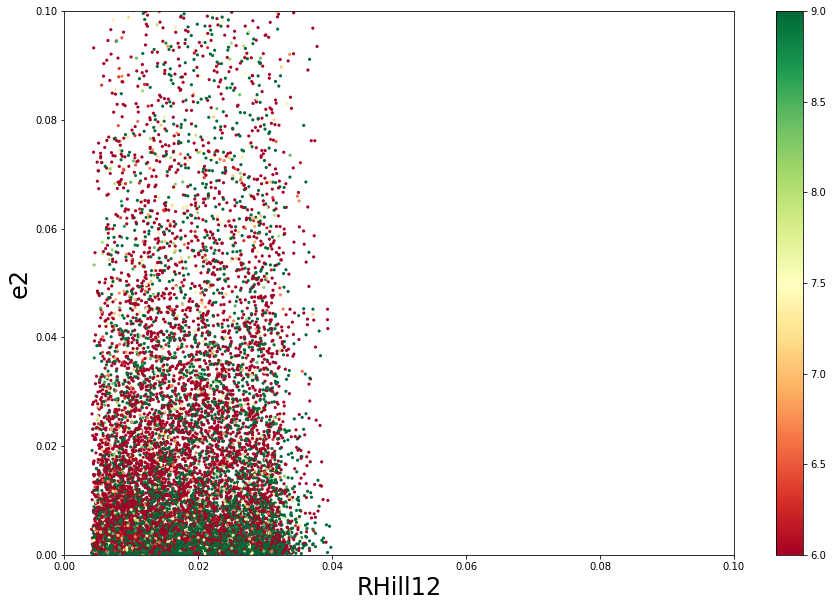

In [59]:
fig, ax = plt.subplots(figsize=(15,10))
cm = plt.cm.get_cmap('RdYlGn')
#dfplot = df #df.loc[df["Norbits"] > 0.]
val1 = "RHill12"
val2 = "e2"
sc = ax.scatter(df_inital[val1], df_inital[val2], c=np.log10(df_inital['instability_time']), edgecolor='', vmin=6,s=10,cmap=cm)
ax.set_xlabel(val1, fontsize=24)
ax.set_ylabel(val2, fontsize=24)
ax.set_xlim([0,0.1])
ax.set_ylim([0,0.1])
plt.colorbar(sc)
plt.show()

In [14]:
#Take from beta12 and beta23 upwards of 20
#merged = df.iloc[:15000, :]
df_same = df.iloc[:15000, :]
merged = pd.concat([df_same, df_inital], axis = 1)
#drop t since its the same as instability change
#del merged["t"]
print merged.loc[4]["t"] == merged.loc[4]["t_shadow"]
print merged.loc[4]["instability_time"] == merged.loc[4]["t_shadow"]

merged.head(15)


True
False


,t,t_shadow,instability_time,RHill12,RHill23,beta12,beta23,m1,a1,P1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,1.235644e+07,8.315081e+07,1.235644e+07,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,0.999983,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,1.348749e+05,2.133072e+05,1.348749e+05,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,1.000000,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,1.276381e+04,9.321519e+03,1.276381e+04,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,0.999963,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,1.000000e+09,1.000000e+09,1.000000e+09,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,1.000000,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,8.791888e+01,8.791888e+01,8.791888e+01,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,1.000000,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392
5,1.000000e+09,1.000000e+09,1.000000e+09,0.020053,0.037523,28.331058,22.457059,7.391032e-06,1.0,0.999996,...,-2.677006,0.082399,2.429857e-05,2.410783,3.743059,0.005295,1.361753,0.063358,1.756039,-0.525618
6,1.493010e+02,1.493010e+02,1.493010e+02,0.026081,0.026966,8.587023,1.013100,2.398945e-05,1.0,0.999988,...,-1.997728,1.212560,2.851700e-06,1.251277,1.399645,0.027982,-2.804719,0.003511,-1.224442,1.668318
7,5.211392e+02,3.210528e+02,5.211392e+02,0.007409,0.014891,3.100652,16.540578,9.364795e-07,1.0,1.000000,...,1.402652,-2.340906,8.970227e-06,1.269280,1.429994,0.001304,-0.328554,0.001379,-2.657141,-3.790768
8,8.313842e-01,8.313842e-01,8.313842e-01,0.029568,0.048262,21.439691,3.470373,4.787597e-07,1.0,1.000000,...,1.471415,0.125609,2.393276e-07,1.801408,2.417694,0.014567,1.676149,0.008059,2.561428,-0.615348
9,1.057243e+02,1.057243e+02,1.057243e+02,0.010789,0.010349,26.130294,1.186617,2.449188e-06,1.0,0.999999,...,0.987448,1.495475,2.603864e-07,1.294191,1.472302,0.014135,-5.586081,0.001207,-3.102203,-0.478592


In [15]:
#indices = []#

#for i, vals in enumerate(df_same.as_matrix()):
#    if vals[0] != vals[1]:
#        indices.append(i)
        
#print len(indices)
#df_diff = df_same.loc[indices]
#df_diff.head(10)

In [16]:
indices = []

for i, vals in enumerate(merged.as_matrix()):
    if vals[0] != vals[1]:
        indices.append(i)
        
print len(indices)
merged2 = merged.loc[indices]
print merged2.shape#
#print merged2.loc[4]["t_shadow"], merged2.loc[4]["instability_time"]
#print merged2.loc[4]["t_shadow"] == merged2.loc[4]["instability_time"]
#print merged2.head(15)
del merged2["instability_time"]
print merged2.shape

6891
(6891, 31)
(6891, 30)


In [45]:
merged3 = merged2[(merged2["t_shadow"]!=1e9) &(merged2["t"]!=1e9)]
                 #&(merged2["t_shadow"]>) &(merged2["instability_time"]>1)]
print merged3.shape
#print merged3.loc[4]["t_shadow"]
#print merged3.loc[4]["instability_time"]
merged4 = merged3[(merged3["beta12"]>20) & (merged3["beta23"]>20)]
print merged4.shape

(6594, 30)
(414, 30)


In [18]:
#merged2 = merged2[(merged2["beta12"]>20) & (merged2["beta23"]>20)]


In [46]:
sigma_shape = np.linspace(0.5,5,45)   
probs = fit_sigma( np.log(merged4[["t_shadow", "t"]].as_matrix()), sigma_range= sigma_shape)
summed_prob = sigma_prob_sum(probs)



Time 0.481286048889


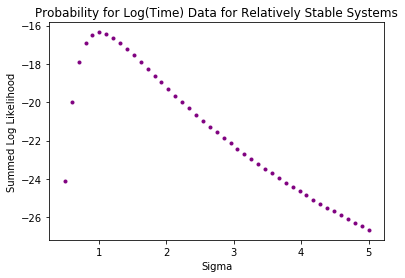

In [47]:
plotting(sigma_shape, summed_prob, "Probability for Log(Time) Data for Relatively Stable Systems")

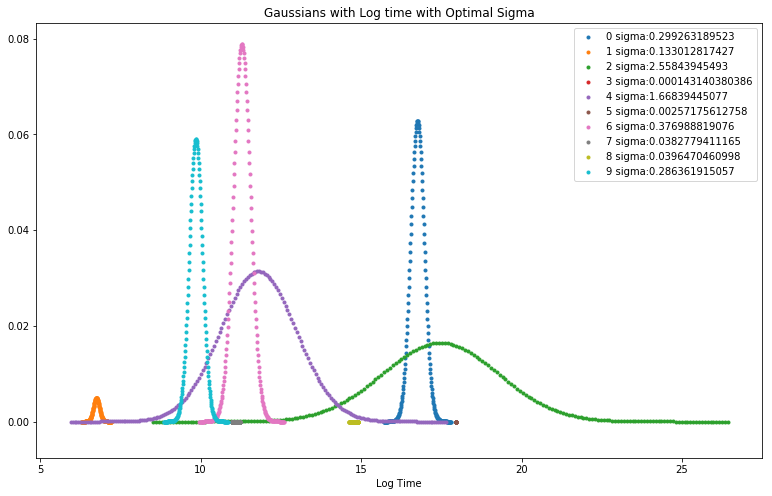

In [21]:
def optimal_sigma(log_times, title ="Gaussians with Log time with Optimal Sigma" ):
    fig = plt.figure(figsize=(13,8))
    ax = fig.add_subplot("111")
    for i, vals in enumerate(log_times[:10, :]):
        mid = np.sum(vals)/2.
        #print vals
        #what is the best sigma given mu?
        sigma = 0.5* np.sum(( vals - mid) **2)
        #print sigma
        #sigma = 2
        start = mid - (num_std*sigma)

        if(start > 0):
            mu = np.linspace(mid - (num_std*sigma) , mid + (num_std*sigma) , 200)
        else:
            mu = np.linspace(0 , mid + (num_std*sigma) , 200)

        values = double_gauss(vals, sigma, mu)
        ax.scatter(mu, values, label = str(i) + " sigma:" + str(sigma), marker = ".")
    plt.title(title)
    plt.xlabel("Log Time")
    plt.legend()
    plt.show()
    
times = np.log(merged4[["t_shadow", "t"]].as_matrix())
optimal_sigma(times)

Try with more stable systems, what if beta12 and 23 are both greater than 25?

(102, 30)
Time 0.127249002457


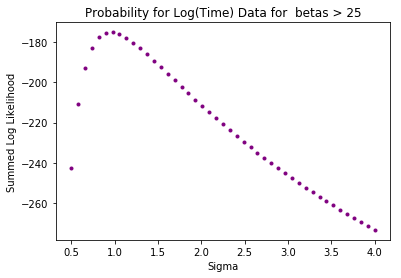

In [22]:
merged4 = merged3[(merged3["beta12"]>25) & (merged3["beta23"]>25)]
print merged4.shape

sigma_shape = np.linspace(0.5,4,45)   
probs = fit_sigma( np.log(merged4[["t_shadow", "t"]].as_matrix()), sigma_range= sigma_shape)
summed_prob = sigma_prob_sum(probs)

plotting(sigma_shape, summed_prob, "Probability for Log(Time) Data for  betas > 25")

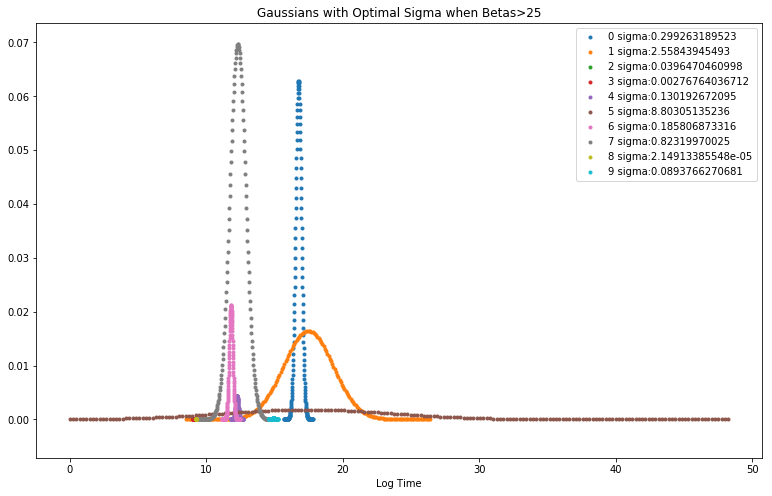

In [23]:
times = np.log(merged4[["t_shadow", "t"]].as_matrix())
optimal_sigma(times, "Gaussians with Optimal Sigma when Betas>25")

(78, 30)
Time 0.10374212265


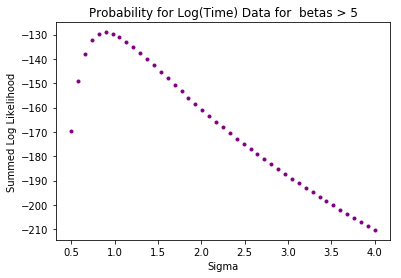

In [24]:
merged4 = merged3[(merged3["beta12"]<5) & (merged3["beta23"]<5)]
print merged4.shape

sigma_shape = np.linspace(0.5,4,45)   
probs = fit_sigma( np.log(merged4[["t_shadow", "t"]].as_matrix()), sigma_range= sigma_shape)
summed_prob = sigma_prob_sum(probs)

plotting(sigma_shape, summed_prob, "Probability for Log(Time) Data for  betas > 5")


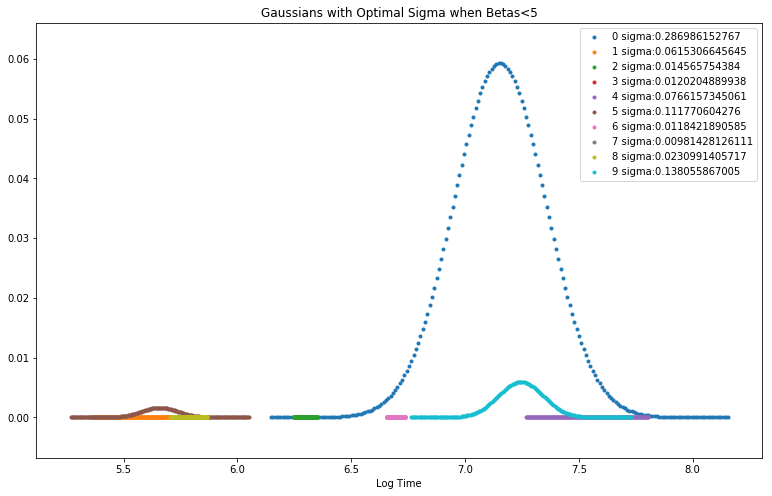

In [25]:
times = np.log(merged4[["t_shadow", "t"]].as_matrix())
optimal_sigma(times, "Gaussians with Optimal Sigma when Betas<5")

In [26]:
print  merged3["e1"].min(), merged3["e1"].max()
print merged3["e2"].min(),  merged3["e2"].max()
print merged3["e3"].min(), merged3["e3"].max()

3.03079258248e-07 0.773736248633
4.01678380017e-06 0.419147178961
1.66459769126e-06 0.442343277127


(95, 30)
Time 0.113758802414


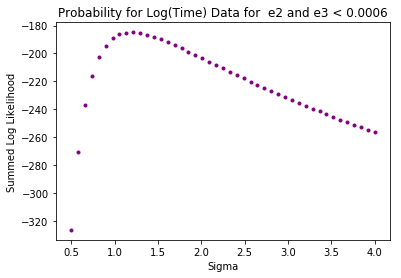

In [27]:
merged4 = merged3[(merged3["e2"]<0.0006) & (merged3["e3"]<0.0006)]
print merged4.shape

sigma_shape = np.linspace(0.5,4,45)   
probs = fit_sigma( np.log(merged4[["t_shadow", "t"]].as_matrix()), sigma_range= sigma_shape)
summed_prob = sigma_prob_sum(probs)

plotting(sigma_shape, summed_prob, "Probability for Log(Time) Data for  e2 and e3 < 0.0006")


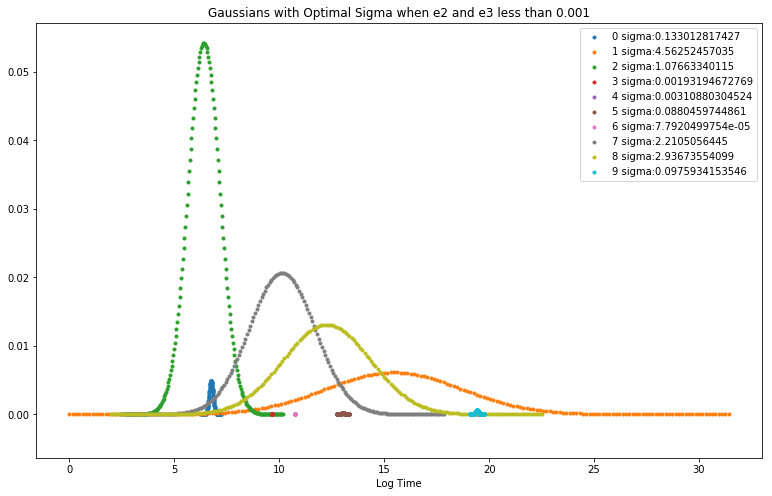

In [28]:
times = np.log(merged4[["t_shadow", "t"]].as_matrix())
optimal_sigma(times, "Gaussians with Optimal Sigma when e2 and e3 less than 0.001")

(198, 30)
Time 0.524909973145


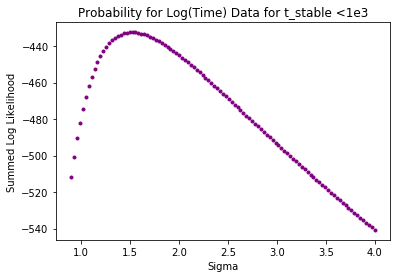

In [29]:
merged4 = merged3[(merged3["t_shadow"]<1e3) & (merged3["t"]>1e3)]
print merged4.shape

sigma_shape = np.linspace(.90,4,105)   
probs = fit_sigma( np.log(merged4[["t_shadow", "t"]].as_matrix()), sigma_range= sigma_shape)
summed_prob = sigma_prob_sum(probs)

plotting(sigma_shape, summed_prob, "Probability for Log(Time) Data for t_stable <1e3")


/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


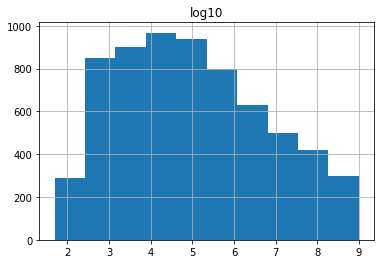

(2346, 31)


/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


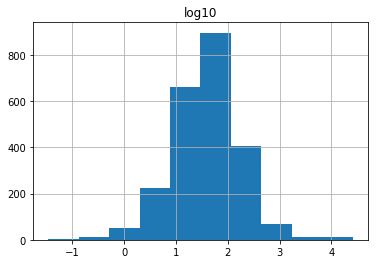

In [78]:
merged3["log10"] = np.log10(merged3["t"])
merged3.hist("log10")
plt.show()

same = merged[(merged["t"] == merged["t_shadow"]) & (merged["t"]!=1e9) 
print same.shape
same["log10"] = np.log10(merged["t"])
same.hist("log10")
plt.show()

(1981, 31)


/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


Time 2.16728305817


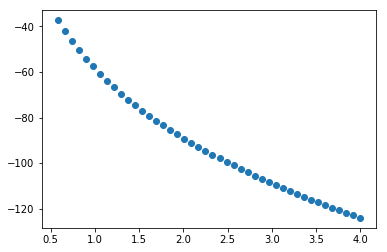

In [82]:
same2 = merged[(merged["t"] == merged["t_shadow"]) & (merged["t"]!=1e9)  & (merged["t"]<150)]
print same2.shape


sigma_shape = np.linspace(0.5,4,45)   
probs = fit_sigma( np.log(same2[["t_shadow", "t"]].as_matrix()), sigma_range= sigma_shape)
summed_prob = sigma_prob_sum(probs)
plt.scatter(sigma_shape, summed_prob)
plt.show()
#same["log10"] = np.log10(merged["t"])
#same.hist("log10")
#plt.show()

(6594, 32)
(414, 32)
Time 0.475698947906
(102, 32)
Time 0.111186981201
(78, 32)
Time 0.0880138874054
(95, 32)
Time 0.102592945099
(336, 32)
Time 0.37210392952


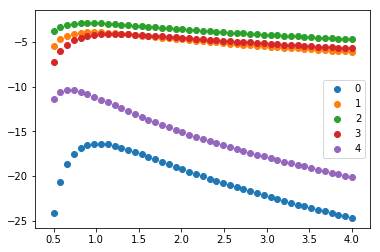

In [86]:
sigma_shape = np.linspace(0.5,4,45)   
print merged3.shape

merged_stable = merged3[(merged3["beta12"]>20) & (merged3["beta23"]>20)]
merged_more_stable = merged3[(merged3["beta12"]>25) & (merged3["beta23"]>25)]
merged_unstable = merged3[(merged3["beta12"]<5) & (merged3["beta23"]<5)]
merged_circle = merged3[(merged3["e2"]<0.0006) & (merged3["e3"]<0.0006)]
merged_very_unstable = merged3[(merged3["t"]<300) ]



samples = [merged_stable, merged_more_stable, merged_unstable, merged_circle, merged_very_unstable]

fig = plt.figure()
ax = fig.add_subplot("111")

for i, data in enumerate(samples):
    print data.shape
    
    probs = fit_sigma( np.log(data[["t_shadow", "t"]].as_matrix()), sigma_range= sigma_shape)
    summed_prob = sigma_prob_sum(probs)
    pos = np.max(summed_prob)
    ax.scatter(sigma_shape, summed_prob, label = str(i) )
        
plt.legend()
plt.show()
